In [2]:
import numpy as np
import pandas as pd
from scipy.special import expit
import pymc as pm
import arviz as az
import json
import os
import seaborn as sns

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.80'


def make_dir(newpath):
    if not os.path.exists(newpath):
        os.makedirs(newpath)

use_cpu = True   
try: 
    import pymc.sampling.jax as pmjaxz
    from jax.lib import xla_bridge
    import matplotlib.pyplot as plt
    print(xla_bridge.get_backend().platform)
    if xla_bridge.get_backend().platform == 'gpu':
        use_cpu = False
    import pymc.sampling.jax as pmjax
except:
    print("No JAX backend")
    use_cpu = True

params = json.load(open('params.json'))
np.random.seed(params['seed'])

%load_ext autoreload
%autoreload 2
%autosave 30

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/.local/lib/python3.8/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


gpu


Autosaving every 30 seconds


# Policy 

For this analysis, we'll be considering how to analyze reports of support for poicy, which range between 0 and 100% agreement. The data contain: 

- 9 measurements per participant
- 50+ countries
- 12 treatments
- Intervention Time

## Step One: Conceptual Analysis 

#### Inferential Goals

We begin by outlining our inferential goals. Here, we're interested in understanding the following: 

- How does support for policy vary across countries? 
- How does treatment impact support for policy? 

Towards these goals, we'll need to consider two additional factors, belief in climate change and intervention time. Belief in climate change is critical, as it is clear that support for climate policy is a consequence of belief in climate change. We would generally expect higher belief to yield higher support for policy, and perhaps to mediate the effect of treatment. One difficulty in evaluating the impact of treatment is that some treatments took longer than others. As a result, observed treatment effects may be biased by the time taken as implemented in this particular survey. We'll want a model that generally accounts for the time required to complete each treatment intervention. 

#### A description of the generative process. 
Participants exist in different countries and are exposed to unique sources of environments that influence their belief in climate change, their overall support for climate policies, and perhaps impact how their belief is converted into support for policy. During our experiment, they are exposed to an intervention which may (at least temporarily) adjust their belief in climate change or simply increase their support without altering their belief. This may be offset by the time the interventions takes, such that more indepth interventions may yield stronger effects---or cause the participant to lose interest. This belief must then be converted by the participant into a 0-100% rating of agreement or disagreement with a series of 9 statements. They may opt to take an extreme position (0 or 100) or alternatively land somewhere in the middle. Our model will need to account for both of these tyeps of views. 

## Step Two: Define Observational Space

The observational space involves categorical variables for treatment and country, positive values for intervention time, belief between 0 and 100% (averaged across 4 items) and policy support between 0 and 100%, for each of 9 items. 

## Step Three: Construct Summary Statsitics
We will use the data without constructing summary statistics.

## Step Four: Model Development

We will adopt the model from Belief, adding country and treatment effects by belief. 

\begin{align}
y_i&\sim\text{ZOIB}(\mu_i, \kappa, \theta, \tau_i)\\
\text{logit}(\tau_i)&= \alpha_\tau  + \beta_\tau \times \mu_i + \text{Item}\\
\text{logit}(\mu_i)&= \alpha_{p,i} + \beta_{p, i} * \text{Belief}\\
\alpha_p &\sim \text{Normal}(\alpha + \text{C}_{0, c[i]} + \text{T}_{0, t[i]}, .5) \\
\beta_p &\sim \text{Normal}(\beta + \text{C}_{1,c[i]} + \text{T}_{1, t[i]}, .5)\\
C, T&\sim \text{MVNormal} \big(\begin{bmatrix}0\\0\end{bmatrix},S\big)\\
S&=\big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big) R \big(\begin{matrix}\sigma_a & 0 \\ 0 & \sigma_b \end{matrix}\big)\\
\sigma_{\alpha}, \sigma_{\beta} &\sim \text{Exponential}(2) \\
\text{Item}&\sim\text{ZeroSumNormal}(.5)\\
\end{align}

We note that the priors here differ somewhat from the belief model, owing to adjustments to improve identifiabilty, particularly with $\sigma$. 


# Step Five: Construct Summary Statistics
We will qualitatively assess trees planning, across prior simulations. No summary statistics will be constructed

In [2]:
import pandas as pd
df = pd.read_excel(params['data']['adj_location'])
df.head()

,Unnamed: 0,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,...,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1,UniqueID,BeliefADJ
0,0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,...,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0,0,3.642990
1,1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,...,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0,1,1.334043
2,2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,...,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0,2,-1.626310
3,3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,...,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0,3,2.011489
4,4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,...,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0,4,2.066036


In [ ]:
params = json.load(open('params.json'))
# params['policy']['priors']

(491922, 6)


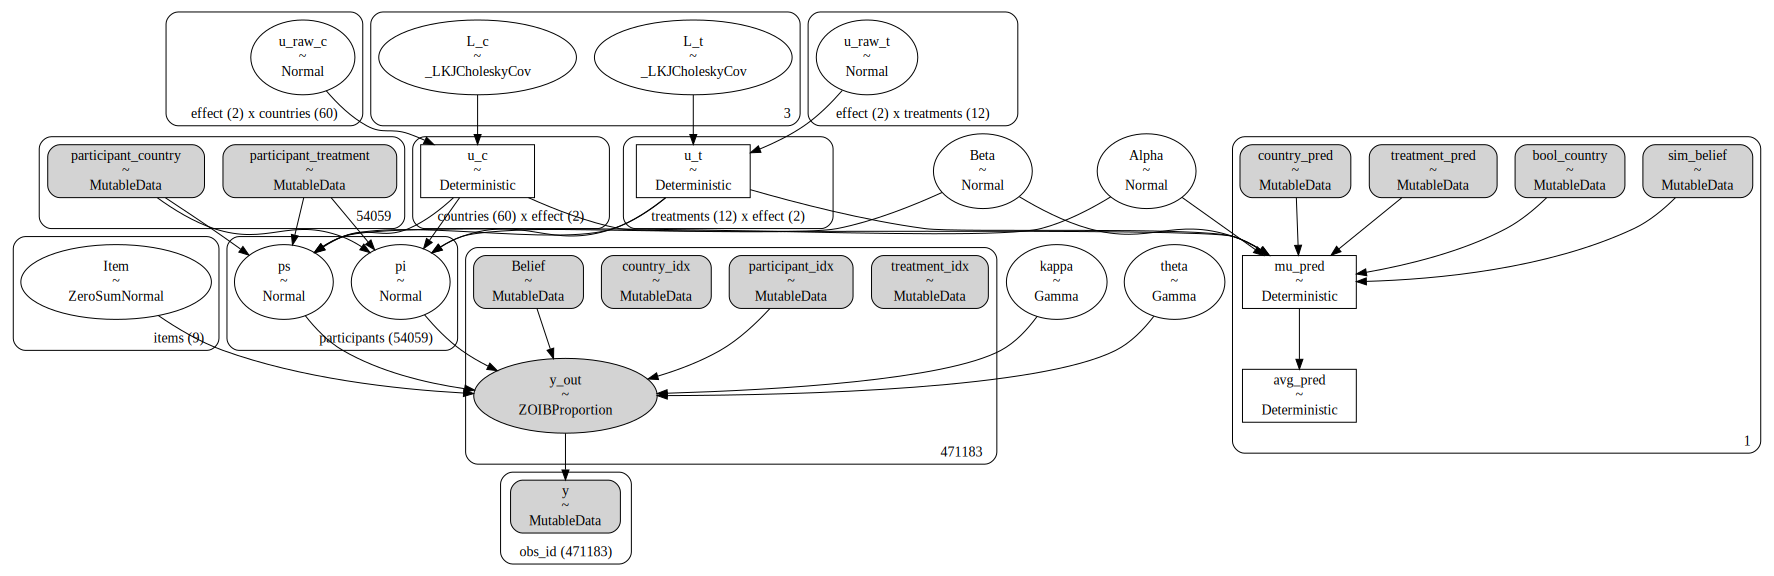

In [9]:
from src.models import get_policy_model


model, temp = get_policy_model(df)#, priors = params['wept']['priors'])

pm.model_to_graphviz(model)

# Step Six: Simulate Bayesian Ensemble

With our priors and model loaded, we can simulate the implications of our structure and prior choice to determine whether we have chosen appropriate priors. Should they appear off, they can be adjusted in `params.json` and reloaded. 


In [10]:
with model: 
    prior_predictive = pm.sample_prior_predictive(samples = 100,
                                                  random_seed=params['seed'])

az.to_netcdf(prior_predictive, './out/posteriors/prior_predictive_policy.nc')

Sampling: [Alpha, Beta, Item, L_c, L_t, kappa, pi, ps, theta, u_raw_c, u_raw_t, y_out]


'./out/posteriors/prior_predictive_policy.nc'

# Step seven: Prior Predictive Checks
Here, we verify that our prior choices produce distributions of policy support consistent with our domain knowledge.

/tmp/ipykernel_90694/1176448966.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


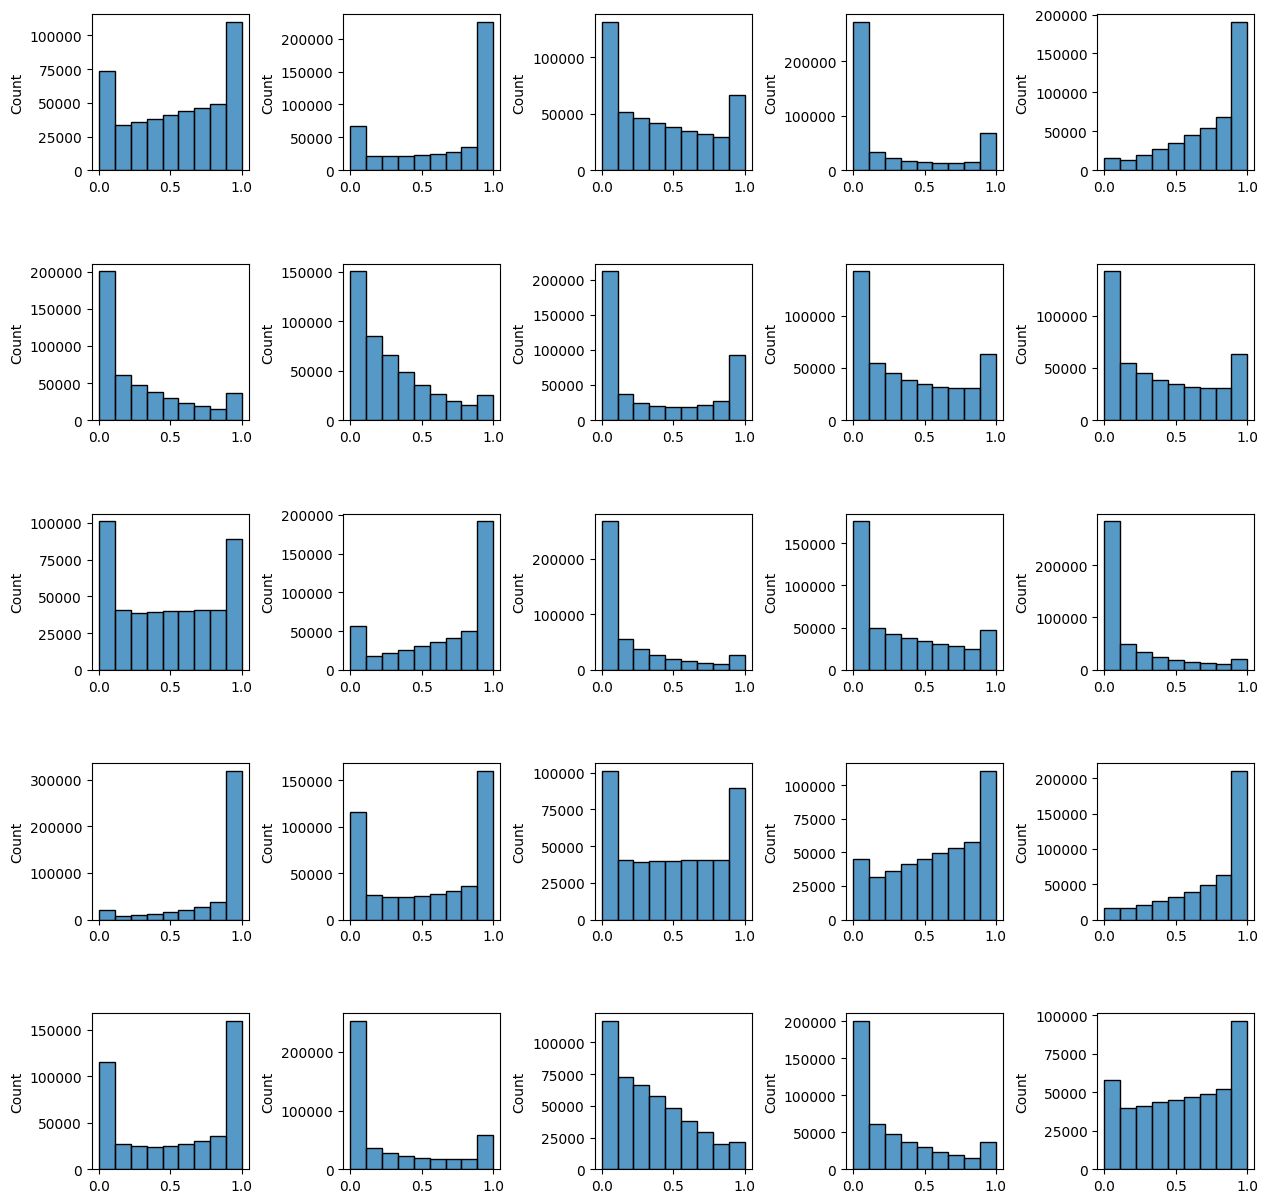

In [13]:
prior_pd = prior_predictive.prior_predictive['y_out']

plt.figure(figsize=(15, 15))
g = plt.GridSpec(5, 5, hspace=0.6, wspace=0.6)

for i in range(5):
    for j in range(5):
        ax = plt.subplot(g[i, j])
        sns.histplot(prior_pd[0, np.random.choice(np.arange(prior_pd.shape[1])), :], 
                     bins=np.linspace(0, 1, 10))
plt.tight_layout()



# Step Eight: Configure Algorithm
We will use default parameters to sample on the GPU. Tune and Draw can be adjusted in params.json

# Step Nine: Fit Simulated Ensemble
As this is computationally challenging, we face some trade-offs between running the model at the full data volume and running the model on sufficient numbers of prior samples to draw conclusions about the inferential adequacy. We will run only 3 fits from the prior distribution, as this can take 4-7 hours per fit. 


In [20]:
var_names = ['u_t', 'u_c', 'Item', 'Alpha', 'Beta','kappa', 'alpha_theta', 'beta_theta']
for name in var_names:
    ranks = (prior_predictive.prior[name].data[0, prior_num] < idata.posterior[name]).sum(dim='chain').sum(dim='draw')
    means =idata.posterior[name].mean(dim=['chain', 'draw'])
    sd = idata.posterior[name].std(dim=['chain', 'draw'])
    prior_var = prior_predictive.prior[name].var(dim=['chain', 'draw'])
    prior_sd = prior_predictive.prior[name].std(dim=['chain', 'draw'])
    prior_mu= prior_predictive.prior[name].mean(dim=['chain', 'draw'])
    prior = prior_predictive.prior[name].data[0, prior_num] 
    var = idata.posterior[name].var(dim=['chain', 'draw'])
    out.append({'name':np.repeat(name, ranks.size),
                'prior_num':np.repeat(prior_num, ranks.size),
                'rank':ranks.values.ravel(),
                'means':means.values.ravel(), 
                'sd':sd.values.ravel(),
                'var':var.values.ravel(),
                'prior_var':prior_var.values.ravel(),
                'prior_sd':prior_sd.values.ravel(),
                'prior':prior.ravel(),
                'prior_mu':prior_mu.values.ravel()})

In [ ]:
#Add zero constrain on control treatment effects. 
from pymc.sampling import jax as pmjax
from src.models import transform_y_for_gpu_ZOIB

prior_num = 0

for prior_num in np.random.choice(np.arange(100), size=3):
    print('Running inference on prior sample: ', prior_num)
    ranked_data = []
    with model:
        model.set_data('y', transform_y_for_gpu_ZOIB(prior_predictive.prior_predictive['y_out'].data[0][prior_num]))
        if use_cpu:
            idata = pm.sample(tune = params['wept']['tune'], draws = params['wept']['draws'], random_seed=params['seed'])
        else: 
            idata = pmjax.sample_numpyro_nuts(chain_method=params['sampling']['chain_method'],
                                        postprocessing_backend=params['sampling']['postprocessing_backend'], 
                                        tune =params['policy']['tune'], 
                                        draws = params['policy']['draws'], random_seed=params['seed'])
        
        out = []
        var_names = ['u_t', 'u_c', 'Item', 'Alpha', 'Beta','kappa', 'alpha_theta', 'beta_theta']
        for name in var_names:
            ranks = (prior_predictive.prior[name].data[0, prior_num] < idata.posterior[name]).sum(dim='chain').sum(dim='draw')
            means =idata.posterior[name].mean(dim=['chain', 'draw'])
            sd = idata.posterior[name].std(dim=['chain', 'draw'])
            prior_var = prior_predictive.prior[name].var(dim=['chain', 'draw'])
            prior_sd = prior_predictive.prior[name].std(dim=['chain', 'draw'])
            prior_mu= prior_predictive.prior[name].mean(dim=['chain', 'draw'])
            prior = prior_predictive.prior[name].data[0, prior_num] 
            var = idata.posterior[name].var(dim=['chain', 'draw'])
            out.append({'name':np.repeat(name, ranks.size),
                        'prior_num':np.repeat(prior_num, ranks.size),
                        'rank':ranks.values.ravel(),
                        'means':means.values.ravel(), 
                        'sd':sd.values.ravel(),
                        'var':var.values.ravel(),
                        'prior_var':prior_var.values.ravel(),
                        'prior_sd':prior_sd.values.ravel(),
                        'prior':prior.ravel(),
                        'prior_mu':prior_mu.values.ravel()})
        ranked_data.append(pd.concat(pd.DataFrame(x) for x in out))

        print('BFMI:')
        print(az.bfmi(idata))
        print('Rhat:')
        print(np.sum(az.summary(idata, var_names=var_names)['r_hat'] > 1.05))
        print('ess_bulk: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_bulk'].min()))
        print('ess_tail: min')
        print(np.sum(az.summary(idata, var_names=var_names)['ess_tail'].min()))
        print('Divergeneces:')
        print(idata.sample_stats['diverging'].sum())
        #idata = pm.sample(tune = params['belief']['tune'], draws = params['belief']['draws'], random_seed=params['seed']) \

    
        pd.concat(ranked_data).to_csv('./out/policy_prior_ranks2.csv')
    print('-------------------------------------')

Examining the posterior predictive contraction vs. z-scores of known parameters is strongly clustered on the right of the graph near zero, with few extreme observations. This suggests adequate model fit, balancing overfit and underfit, and priors that are not causing the model to behave poorly. We will continue fitting the model. 

# Step Ten: Algorithmic Calibration
Default parameters look good, we'll use those. 

# Step Eleven: Inferential Calibration
This leaves us to check the ensemble behavior of our recovered posterior distributions which looks reasonable for both parameters.

In [18]:
df_temp = pd.read_csv('./out/policy_prior_ranks2.csv')

FileNotFoundError: [Errno 2] No such file or directory: './out/policy_prior_ranks2.csv'

In [22]:
df_temp['z_score'] = (df_temp['means']-df_temp['prior'])/df_temp['prior_sd']
df_temp['contraction'] = 1-df_temp['var']/df_temp['prior_var']

In [23]:

df_temp=df_temp[df_temp['means']!=0]
plt.scatter(df_temp['contraction'], df_temp['z_score'], alpha=.2)
plt.xlim(0,1)
plt.ylim(-4, 4)
plt.xlabel('Posterior Contraction')
plt.ylabel('Posterior Z-Score')

# Step Twelve: Fit the Observation

Confident in the performance of our model within the scope of its own assumptions we go back to fit the observed data. 

In [35]:
#reload data, parameters

params = json.load(open('params.json'))
df = pd.read_excel(params['data']['adj_location'])
df.head()


,Unnamed: 0,ResponseId,Country,cond,condName,Intervention_order,Intro_Timer,Intervention_Timer,BELIEFcc,POLICYcc,...,Gender,Age,Edu,Politics2_1,Politics2_9,Income,MacArthur_SES,PerceivedSciConsensu_1,UniqueID,BeliefADJ
0,0,R_3KOO2oUWQNtKzrD,Algeria,8,PluralIgnorance,PolicySupport|SocialmediasharingPipedText|Beli...,7.074,28.758,100.00,64.666667,...,1.0,25.0,3.0,53.0,53.0,4.0,4.0,86.0,0,3.642990
1,1,R_3OdqhjO2quQKaIx,Algeria,12,BindingMoral,BeliefinAnthrCC|SocialmediasharingPipedText|Po...,32.089,27.999,73.25,58.111111,...,1.0,35.0,4.0,92.0,36.0,6.0,10.0,31.0,1,1.334043
2,2,R_2QuK4DRmnWL9FXS,Algeria,10,DynamicNorm,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,17.598,54.658,3.00,56.555556,...,3.0,18.0,2.0,100.0,88.0,9.0,4.0,50.0,2,-1.626310
3,3,R_1DYkviJgtp5u6JV,Algeria,7,PsychDistance,SocialmediasharingPipedText|BeliefinAnthrCC|Po...,10.951,299.309,90.75,95.555556,...,1.0,32.0,3.0,93.0,82.0,2.0,3.0,4.0,3,2.011489
4,4,R_1rqWNg0k27FgrE4,Algeria,12,BindingMoral,PolicySupport|BeliefinAnthrCC|Socialmediashari...,5.465,7.302,76.50,67.250000,...,2.0,29.0,4.0,NaN,NaN,3.0,7.0,100.0,4,2.066036


In [36]:
from src.models import get_policy_model
model, temp = get_policy_model(df)


(491922, 6)


In [37]:
with model:
    if use_cpu: 
        idata = pm.sample(cores = params['sampling']['cores'], 
                        tune = params['share']['tune'],
                        draws = params['share']['draws'], 
                        random_seed=params['seed'])
    else:
        idata = pmjax.sample_numpyro_nuts(chain_method='sequential',
                                        postprocessing_backend='cpu', 
                                        tune = params['wept']['tune'],
                                        draws = params['wept']['draws'], random_seed=params['seed'])


Compiling...
Compilation time =  0:00:10.218244
Sampling...


sample: 100%|██████████| 2000/2000 [14:08<00:00,  2.36it/s, 127 steps of size 3.68e-02. acc. prob=0.86]  


Sampling time =  0:56:28.968747
Transforming variables...
Transformation time =  0:00:01.825297


In [38]:
az.to_netcdf(idata, params['policy']['idata_location'])

'./out/posteriors/policy.nc'

#  Step Thirteen: Diagnose posterior fit

In [39]:
idata.sample_stats['diverging'].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [40]:
az.summary(idata, var_names=['u_t', 'u_c', 'Item', 'Alpha', 'Beta','kappa', 'theta']).sort_values('r_hat', ascending=False)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"u_c[China, intercept]",0.178,0.078,0.032,0.321,0.005,0.004,232.0,728.0,1.03
"u_c[Brazil, intercept]",0.073,0.049,-0.021,0.162,0.002,0.002,423.0,601.0,1.02
"u_c[China, belief]",0.063,0.053,-0.032,0.164,0.003,0.002,281.0,899.0,1.02
"u_c[Portugal, intercept]",0.046,0.086,-0.119,0.204,0.005,0.003,339.0,491.0,1.02
"u_c[Portugal, belief]",-0.089,0.042,-0.169,-0.013,0.002,0.001,404.0,827.0,1.02
...,...,...,...,...,...,...,...,...,...
"u_c[Latvia, intercept]",-0.127,0.047,-0.213,-0.038,0.001,0.001,1369.0,2292.0,1.00
"u_c[Kenya, belief]",-0.101,0.039,-0.173,-0.025,0.001,0.001,734.0,1636.0,1.00
"u_c[Kenya, intercept]",0.129,0.070,0.003,0.258,0.003,0.002,550.0,1136.0,1.00
"u_c[Japan, belief]",-0.029,0.025,-0.072,0.022,0.001,0.001,1098.0,1438.0,1.00


In [41]:
az.bfmi(idata)

array([0.92541673, 0.98680336, 1.01122372, 0.89746669])

#  Step Fourteen: Posterior Retrodictive Fit

In [30]:
with model:
   ppc = pm.sample_posterior_predictive(idata, var_names=["y_out"])


Sampling: [y_out]


In [31]:
idata.extend(ppc)

idata.rename({'y_out_dim_0':'obs_id', 'y_out_dim_2':'obs_id'}, inplace=True)
idata = idata.assign_coords(obs_id=temp['condName'].values,  groups="observed_vars")


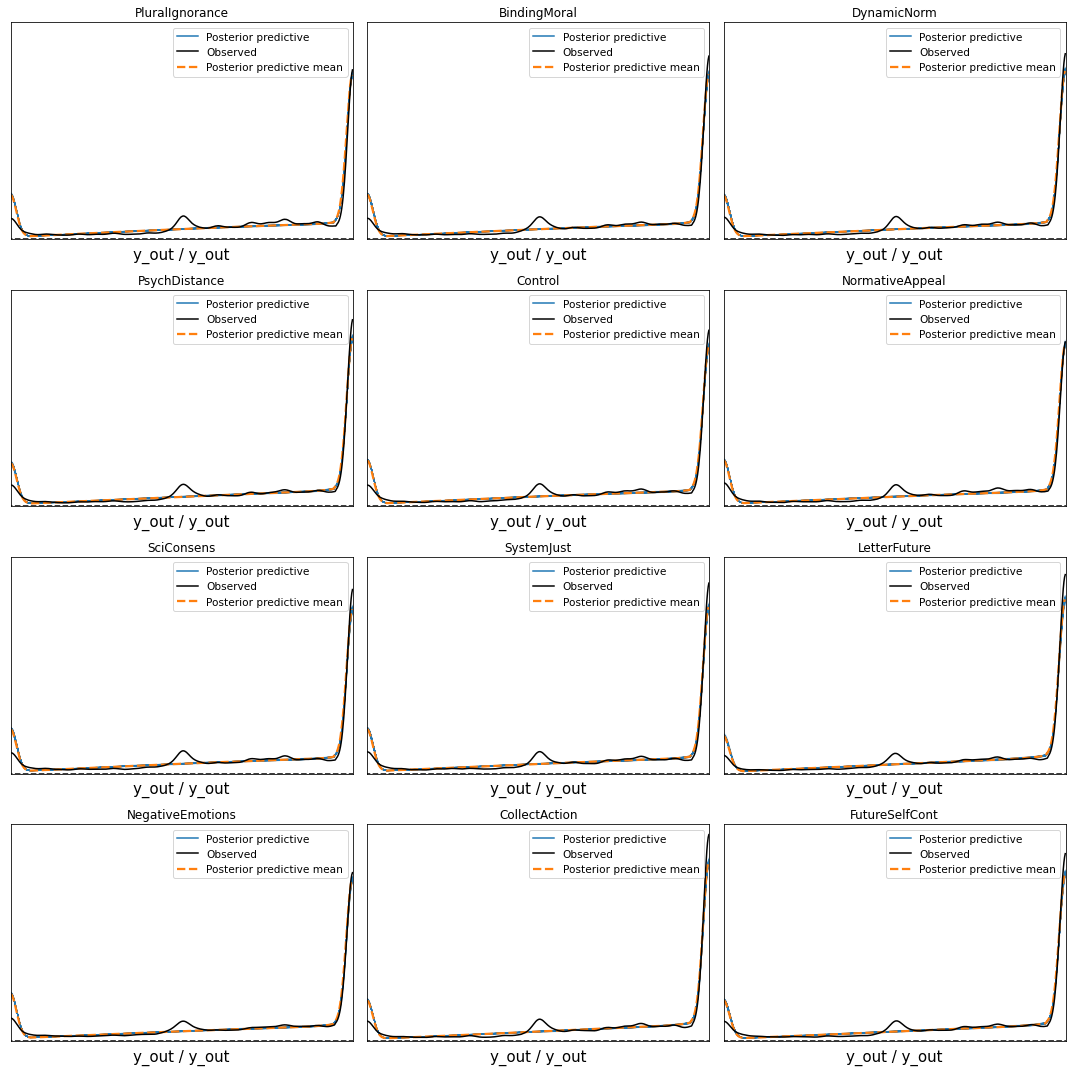

In [32]:
g = plt.GridSpec(4, 3, figure=plt.figure(figsize=(15, 15)))

mu = np.mean((idata.posterior_predictive.sel(obs_id='Control')['y_out']==9).data)
condName = temp['condName'].unique()[0]
for i, condName in enumerate(temp['condName'].unique()):
    ax = plt.subplot(g[i//3, i%3])
    az.plot_ppc(idata, coords={'obs_id': [condName]}, num_pp_samples=200, ax=ax)
    ax.set_title(condName)
    ax.set_xticks(np.arange(1, 10)+.5, np.arange(0, 9))
    plt.plot([-10,20], [mu,mu], ls='--', color='k')
    plt.xlim(0,1)
plt.tight_layout()

#Find the largest y axis size and set all to that size
max_ylim = (1)
for ax in plt.gcf().axes:
    ylim = ax.get_ylim()
    if ylim[1] > max_ylim:
        max_ylim = ylim[1]
for ax in plt.gcf().axes:
    ax.set_ylim(0, max_ylim)




In [33]:
temp.head()

,UniqueID,Country,condName,BeliefADJ,Item,Policy,country_idx,treatment_idxs,Belief
0,0,Algeria,PluralIgnorance,3.642990,Policy1,1.0,0,0,3.642990
1,1,Algeria,BindingMoral,1.334043,Policy1,15.0,0,1,1.334043
2,2,Algeria,DynamicNorm,-1.626310,Policy1,0.0,0,2,-1.626310
3,3,Algeria,PsychDistance,2.011489,Policy1,70.0,0,3,2.011489
4,4,Algeria,BindingMoral,2.066036,Policy1,10.0,0,1,2.066036


In [34]:
temp['y_hat'] = 100 * idata.posterior_predictive['y_out'].median(dim=('chain', 'draw'))
plt.scatter(temp.groupby(['condName', 'Country'])['Policy'].mean().values, 
           temp.groupby(['condName', 'Country'])['y_hat'].mean().values, alpha=.1)
plt.plot([0, 100], [0, 100], ls='--')